# Example notebook to showcase the usage of the Poisson VAE model

We showcase the model on a 10X ATAC sample dataset. The data can be downloaded from [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard). If you want to see how to integrate the model with a Signac analysis workflow, see the notebook `scvi_tools_example_notebook_in_R.ipynb`

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scanpy as sc
import anndata as ad

You can install a forked version of `scvi-tools` with the Poisson VAE model from `https://github.com/lauradmartens/scvi-tools`. We will try to merge it with `scvi-tools` soon.
Run `pip install .` in the cloned repository.

In [3]:
import scvi

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You will only need the `poisson_atac` package for diagnostic plots (e.g. distribution of counts). You can install the `poisson_atac` package from `https://github.com/theislab/scatac_poisson_reproducibility`.
Run `pip install .` in the cloned repository.

In [4]:
import poisson_atac as patac

In [5]:
data_path = '/s/project/poisson_atac/anndata/' #

In [6]:
scvi.__version__

'1.0.3'

## Load the data

In [7]:
adata = sc.read_10x_h5(os.path.join(data_path, '10k_Human_PBMCs_ATAC_v2_Chromium_Controller', '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5'), gex_only=False)

In [8]:
adata

AnnData object with n_obs × n_vars = 10246 × 165434
    var: 'gene_ids', 'feature_types', 'genome'

## Plot count distributions

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib

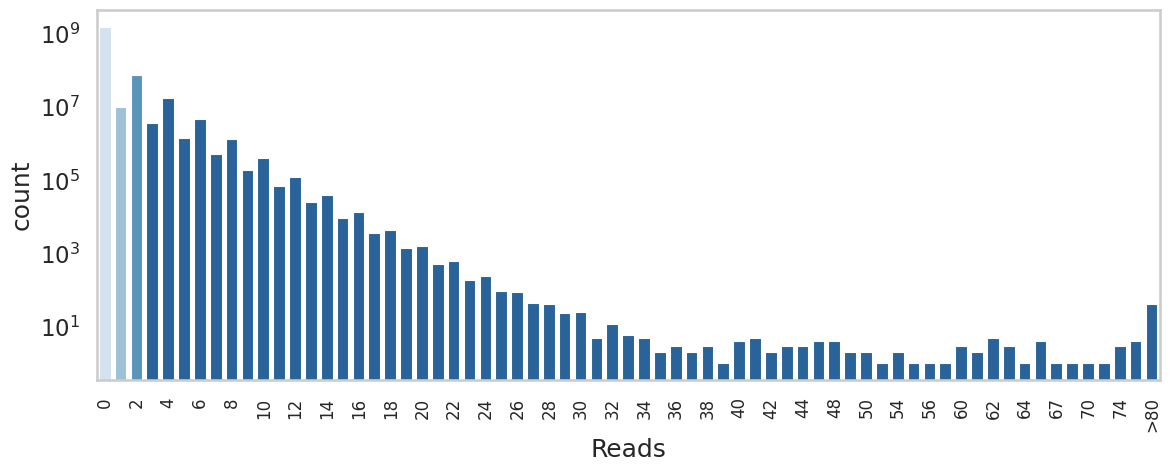

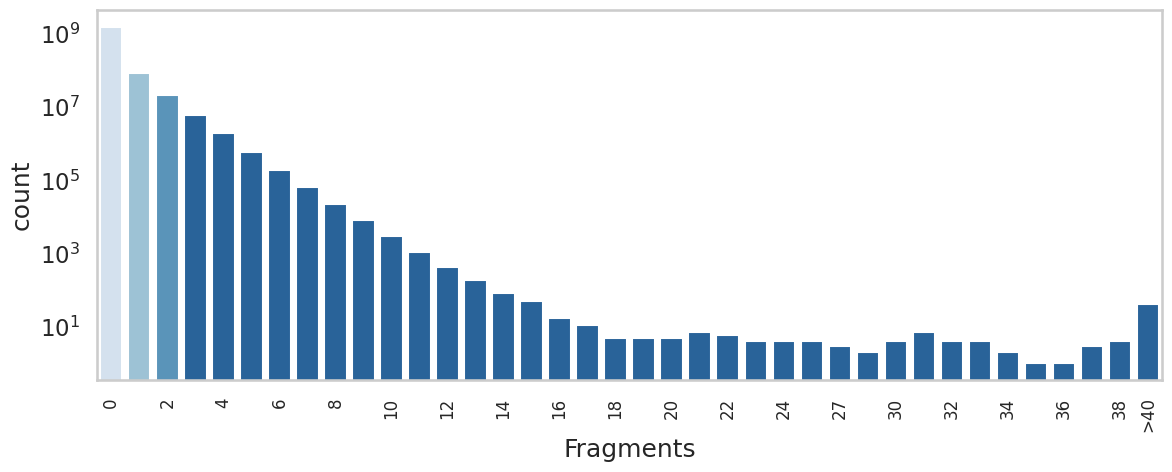

In [9]:
patac.pl.count_distribution(adata, figsize=(12, 5), limit=80)

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


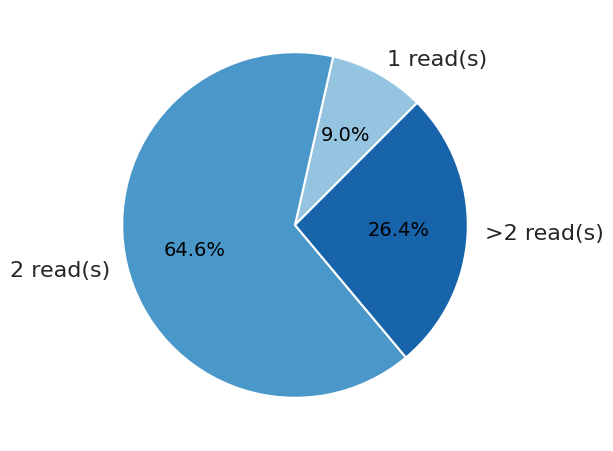

In [10]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=2)

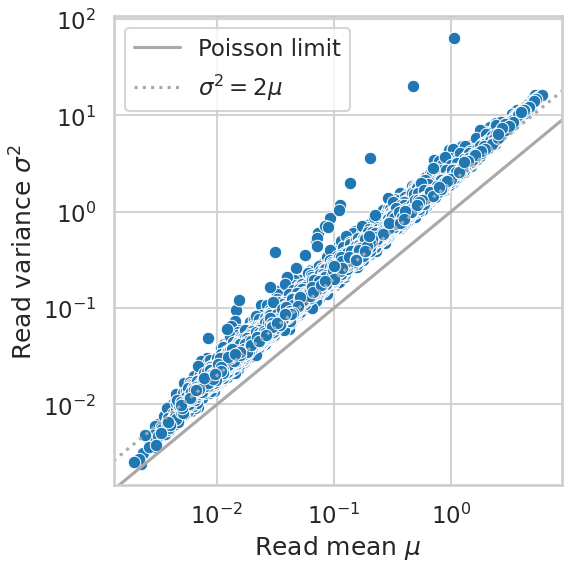

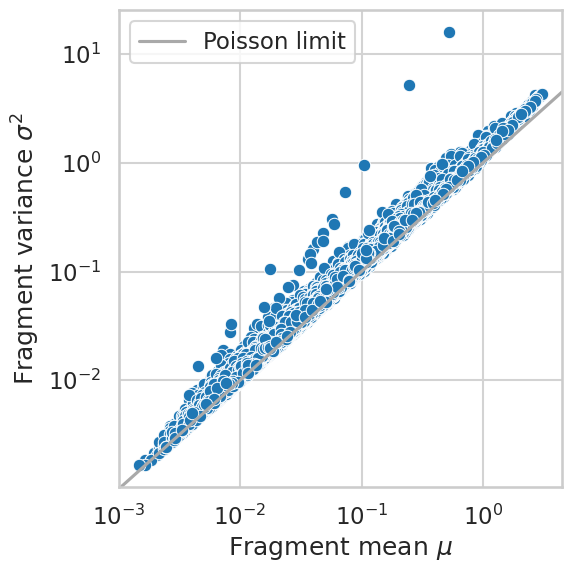

In [11]:
patac.pl.mean_variance(adata, figsize=(6,6))

## Convert to fragment counts

Stores fragment counts into a counts layer

In [12]:
scvi.data.reads_to_fragments(adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 10246 × 165434
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'fragments'

## Setup PoissonVAE model

The model is based on the scvi models. They have a great documentation at https://scvi-tools.org/. Here you will also find more information on the parameters you can use in the setup and training of the model.

In [14]:
scvi.external.POISSONVI.setup_anndata(adata, layer="fragments") # if you have batches use batch='batch_key'

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [15]:
model = scvi.external.POISSONVI(adata)

In [16]:
model

PoissonVI Model with the following params: 
n_hidden: 406, n_latent: 20, n_layers: 2, dropout_rate: 0.1, peak_likelihood: poisson, latent_distribution: normal
Training status: Not Trained

## Train PoissonVAE model

In [17]:
model.train(train_size=0.9, validation_size=0.1)

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A40') tha

Epoch 94/500:  19%|█▉        | 94/500 [08:27<36:31,  5.40s/it, v_num=1, train_loss_step=3.22e+4, train_loss_epoch=3.43e+4]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 35501.645. Signaling Trainer to stop.


## Save model

In [18]:
model.save('python_model.p', overwrite=True)

In [20]:
scvi.external.POISSONVI.load('python_model.p', adata=adata)

INFO     File python_model.p/model.pt already downloaded                                                           


/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/pyt ...
  rank_zero_warn(


PoissonVI Model with the following params: 
n_hidden: 406, n_latent: 20, n_layers: 2, dropout_rate: 0.1, peak_likelihood: poisson, latent_distribution: normal
Training status: Trained

## Load model

In [21]:
model = scvi.external.POISSONVI.load('python_model.p', adata=adata)

INFO     File python_model.p/model.pt already downloaded                                                           


/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/pyt ...
  rank_zero_warn(


## Compute and plot embedding

In [22]:
# Get latent embedding of cells
X_emb = model.get_latent_representation(adata)
adata.obsm['X_emb'] = X_emb

In [23]:
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/p

In [24]:
sc.tl.leiden(adata)

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


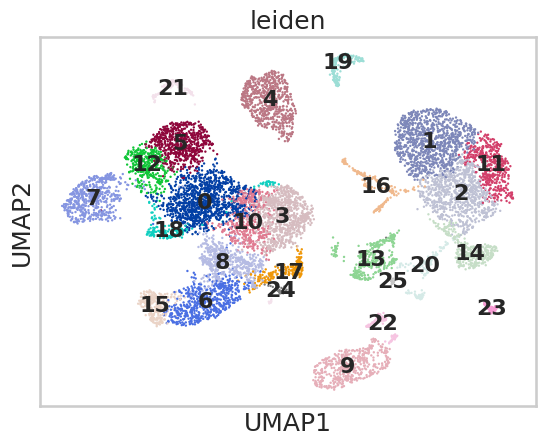

In [25]:
sc.pl.umap(adata, color="leiden", legend_loc = 'on data')

We could do further cell type annotation by looking at the gene activity of marker genes or by integrating it with scRNA-seq. To see an example how to do run the model with Signac, we refer to the notebook `scvi_tools_example_notebook_in_R.ipynb`

# Compute differentially accessible regions

We will compute differentially accessible regions per cluster, which could help us to annotate them. For this, we set two sided to `False` as we want to identify regions for which a cluster has significantly higher accessibility compared to all other clusters. 

In [27]:
da_peaks_13 = model.differential_accessibility(adata, groupby='leiden', group1='13')

DE...: 100%|██████████| 1/1 [00:31<00:00, 31.13s/it]


We will filter for peaks that have at least 5% of cells with non-zero counts in a cluster. This is equivalent to the `min.pct` argument of the `FindMarkers` function in Seurat.

In [28]:
#da_peaks_filt = da_peaks_13[(da_peaks_13.non_zeros_proportion1 >= 0.05)]

AttributeError: 'DataFrame' object has no attribute 'non_zeros_proportion1'

/opt/modules/i12g/anaconda/envs/scvi-tools-2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


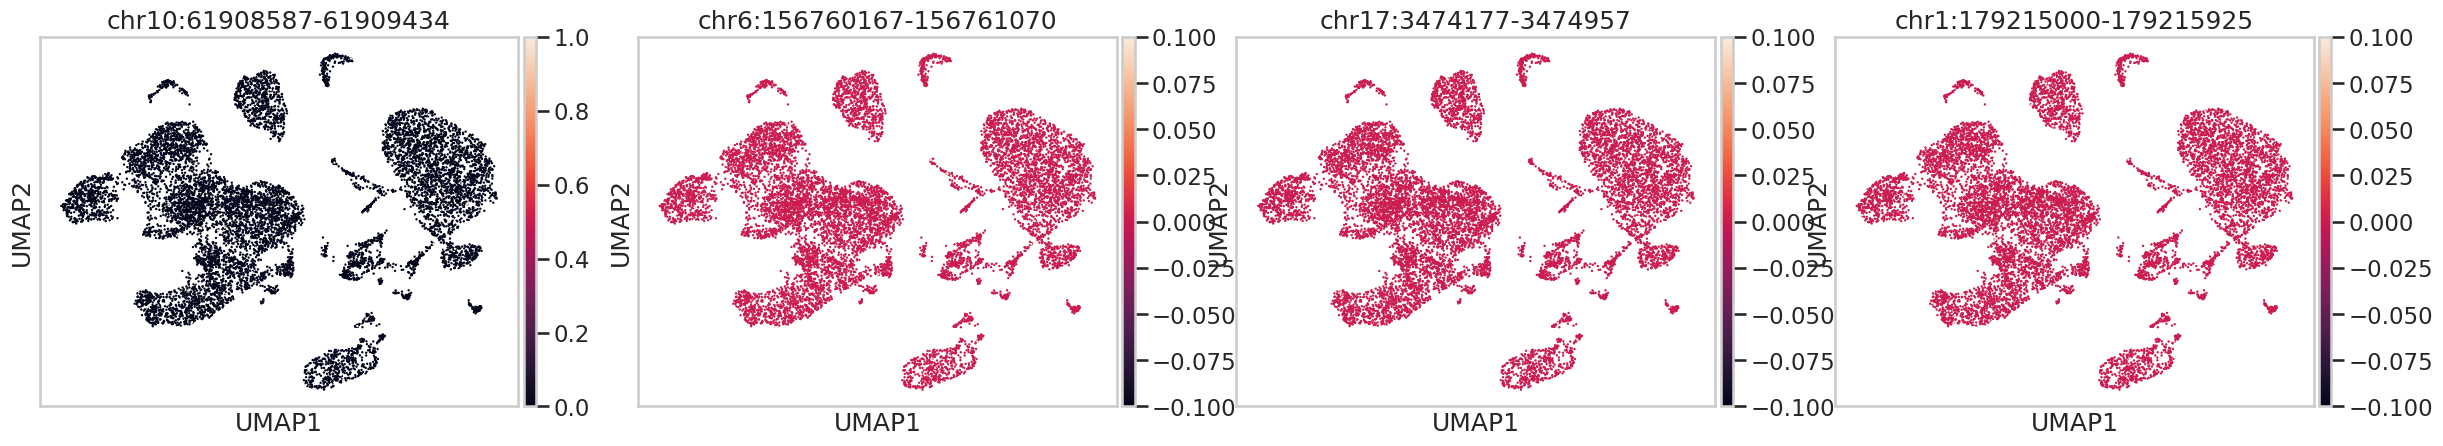

In [33]:
sc.pl.umap(adata, color=da_peaks_13.index[:4], layer='fragments', vmax='p99.0')

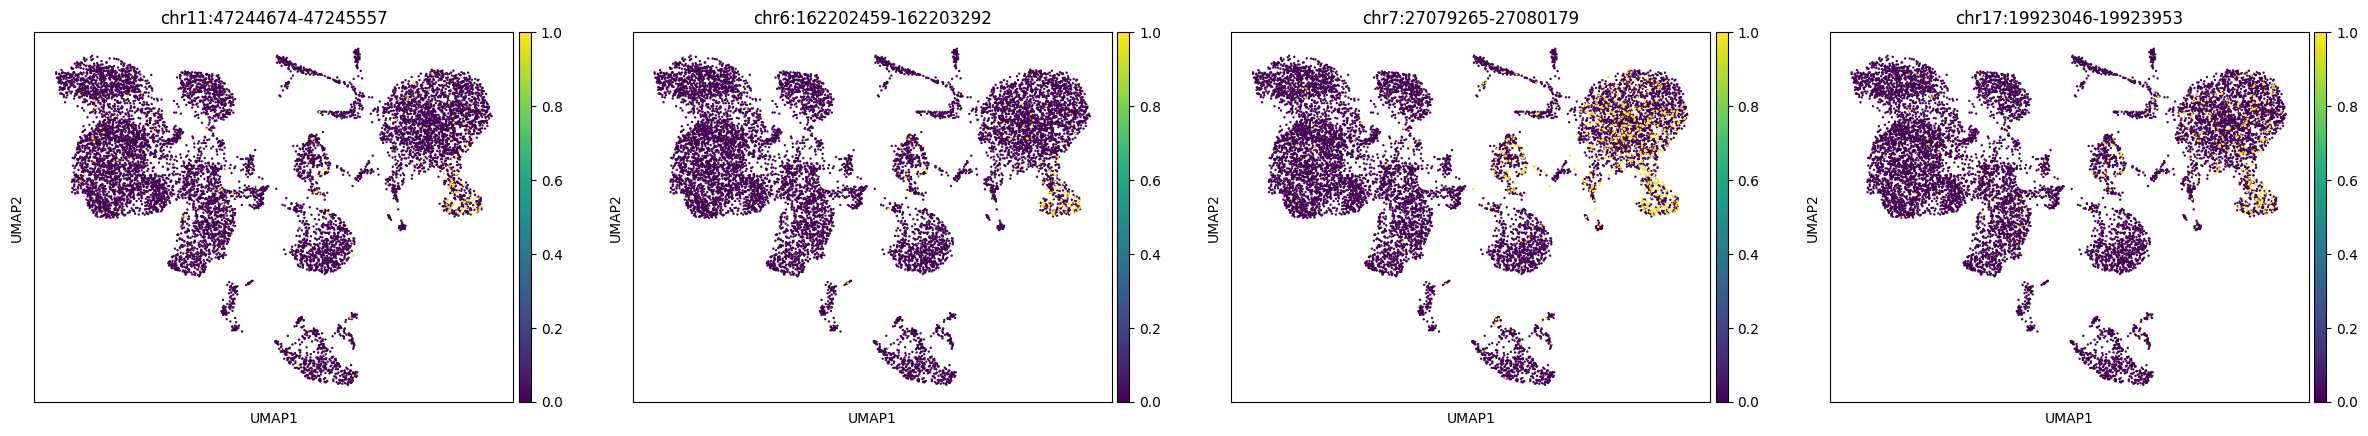

In [47]:
sc.pl.umap(adata, color=da_peaks_filt.index[:4], layer='counts', vmax='p99.0')

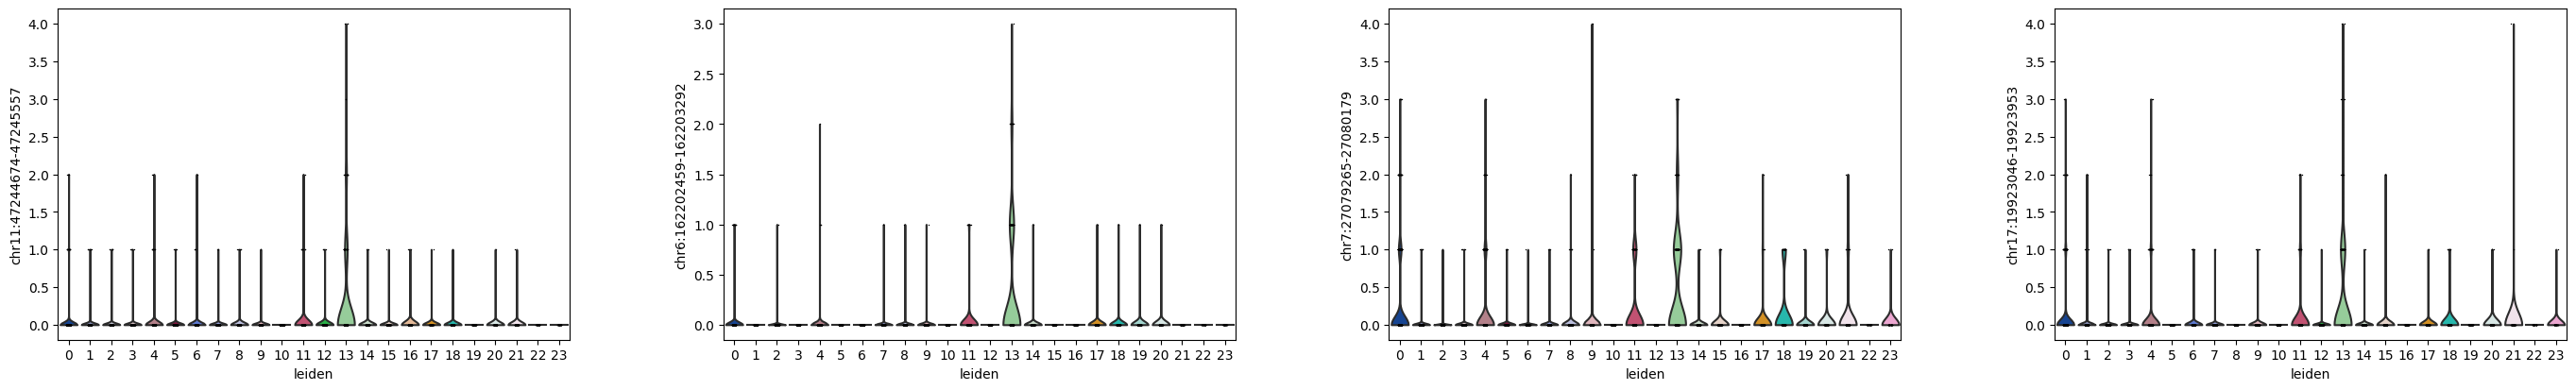

In [42]:
sc.pl.violin(adata, keys=da_peaks_filt.index[:4], groupby='leiden', layer='counts')